In [66]:
import pandas as pd
import h5py
import os
import numpy as np
from selenobot.utils import DATA_DIR, MODELS_DIR, RESULTS_DIR
from selenobot.datasets import Dataset
# from scipy.stats import f_oneway, kstest
# import scipy
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
from selenobot.classifiers import *
import scipy.stats
from typing import List, Tuple, Dict, NoReturn
from tqdm import tqdm
from selenobot.files import MyProteinsFile
from sklearn.metrics import balanced_accuracy_score

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


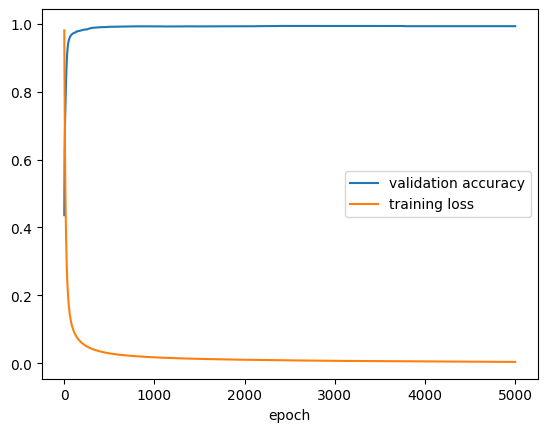

Best validation accuracy: 0.9927678485901781
Best epoch: 4999


In [94]:
model = Classifier.load(os.path.join(MODELS_DIR, 'model_epochs_5000_lr_e8.pkl'))

fig, ax = plt.subplots()
ax.plot(np.arange(len(model.val_accs)), model.val_accs)
ax.plot(np.arange(len(model.train_losses)), model.train_losses)

ax.set_xlabel('epoch')

ax.legend(['validation accuracy', 'training loss'])
plt.show()

print('Best validation accuracy:', model.val_accs[model.best_epoch])
print('Best epoch:', model.best_epoch)

In [95]:
test_dataset = Dataset(pd.read_csv(os.path.join(DATA_DIR, 'test.csv')).set_index('gene_id'))
test_predictions = model.predict(test_dataset)

print('Test accuracy:', balanced_accuracy_score(test_dataset.labels, test_predictions))

# For 2000 epochs, learning rate e-8: 0.9943182517917055
# For 1000 epochs, learning rate e-6: 0.9891197858353995
# For 1000 epochs, learning rate e-7: 0.9915394770126511
# For 1000 epochs, learning rate e-8: 0.9939928067866008


Test accuracy: 0.99374176885876


# Dataset exploration

In [15]:
sec_fasta_file = MyProteinsFile(os.path.join(DATA_DIR, 'sec.fa'))
sec_truncated_fasta_file = MyProteinsFile(os.path.join(DATA_DIR, 'sec.fa'))
sprot_fasta_file = MyProteinsFile(os.path.join(DATA_DIR, 'sprot.fa'))

print('Number of selenoproteins:', len(sec_fasta_file))
print('Number of selenoproteins (truncated):', len(sec_truncated_fasta_file))
print('Number of SwissProt sequences:', len(sprot_fasta_file))

Number of selenoproteins: 18988
Number of selenoproteins (truncated): 18988
Number of SwissProt sequences: 569539


In [4]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), usecols=['gene_id'])
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'), usecols=['gene_id'])
val_df = pd.read_csv(os.path.join(DATA_DIR, 'val.csv'), usecols=['gene_id'])

print('Size of training data:', len(train_df))
print('Size of testing data:', len(test_df))
print('Size of validation data:', len(val_df))

Size of training data: 374775
Size of testing data: 119485
Size of validation data: 94000


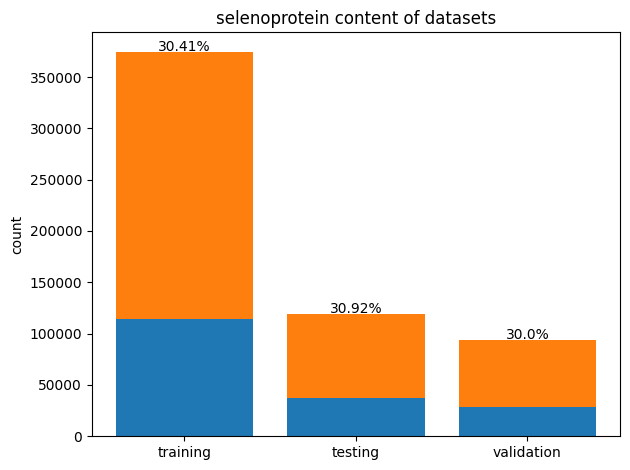

In [22]:
fig, ax = plt.subplots()

sec, non_sec = [], []
for i, df in enumerate([train_df, test_df, val_df]):
    n = np.sum(df.gene_id.str.contains(r'[1]'))
    sec.append(n)
    non_sec.append(len(df) - n)

    ax.text(i, len(df) + 1000, str(np.round(n / len(df) * 100, 2)) + '%', ha='center')

ax.bar(np.arange(3), sec)
ax.set_title('selenoprotein content of datasets')
ax.bar(np.arange(3), non_sec, bottom=sec)
ax.set_ylabel('count')
ax.set_xticks(np.arange(3), labels=['training', 'testing', 'validation'])

plt.tight_layout()

plt.show()


In [17]:
print(len(train_df) + len(val_df) + len(test_df))
print(len(sec_fasta_file) + len(sprot_fasta_file))

588260
588527


In [18]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), index_col=0)

In [19]:
X = train_df[[str(i) for i in range(1024)]].values
y = train_df.label.values

In [ ]:
p_ref = 0.05 
p_vals = []
n = 50

for feature in tqdm(X.T):
    feature = np.random.choice(feature, n)
    mean, std = np.mean(feature), np.std(feature)
    # Null hypothesis is that the two distributions are identical, i.e. the data fit the normal distribution. 
    dist = lambda x : scipy.stats.norm.cdf(x, loc=mean, scale=std)
    p = kstest(feature, dist).pvalue
    p_vals.append(p)

print('Number of features which fit a normal distribution:', np.sum(np.array(p_vals) > p_ref))

# The lack of normality could be due to the fact that the sample size is big, as per https://datatab.net/tutorial/test-of-normality 
# Perhaps if I down-sample the data it would be better. 

In [ ]:
# kbest = SelectKBest(f_classif)
# kbest.fit(X, y)

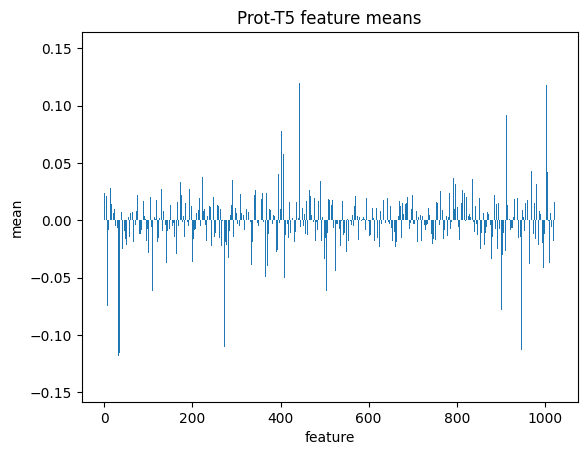

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Prot-T5 feature means')
ax.set_ylabel('mean')
ax.set_xlabel('feature')
ax.bar(np.arange(X.shape[1]), X.mean(axis=0))
plt.show()

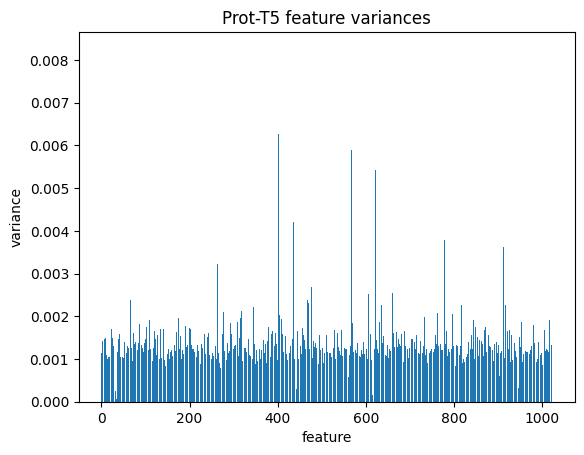

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Prot-T5 feature variances')
ax.set_ylabel('variance')
ax.set_xlabel('feature')
ax.bar(np.arange(X.shape[1]), X.var(axis=0))
plt.show()

In [ ]:
print('Path exists:', os.path.exists('/home/prichter/Downloads/RS_GCF_000238295.3_embedding.h5'))
# example_embedding_path = '/home/prichter/Downloads/RS_GCF_000238295.3_embedding.h5'
example_embedding_path = '/home/prichter/Downloads/GB_GCA_019232935.1_embedding.h5'

Path exists: True


In [31]:
gtdb_results_df = pd.read_csv(os.path.join(RESULTS_DIR, 'gtdb_results.csv'), dtype={'partial':str})

# Make sure there is only one prediction per gene. 
assert len(gtdb_results_df.gene_id.unique()) == len(gtdb_results_df)
# Make sure there is actually a prediction for every gene. 
assert np.all(gtdb_results_df.prediction == 1)

n = len(gtdb_results_df)
gtdb_results_df = gtdb_results_df[gtdb_results_df.partial.str.match('00')] # Look at only totally complete genes...
print(f'Removed {n - len(gtdb_results_df)} incomplete proteins. {len(gtdb_results_df)} predicted selenoproteins remaining.')

n = len(gtdb_results_df)
gtdb_results_df = gtdb_results_df[gtdb_results_df.sec_trna_count > 0] # Require at least one Sec tRNA. 
print(f'Removed {n - len(gtdb_results_df)} with no Sec tRNA. {len(gtdb_results_df)} predicted selenoproteins remaining.')

Removed 1918199 incomplete proteins. 4475890 predicted selenoproteins remaining.
Removed 3511684 with no Sec tRNA. 964206 predicted selenoproteins remaining.


In [61]:
 for stop_codon, df in gtdb_results_df.groupby('stop_codon'):
    print(stop_codon, len(df))

n = len(gtdb_results_df)
gtdb_results_df = gtdb_results_df[gtdb_results_df.stop_codon.str.match('TGA')] # Require at least one Sec tRNA. 
print(f'Removed {n - len(gtdb_results_df)} without a UGA stop codon. {len(gtdb_results_df)} predicted selenoproteins remaining.')


TGA 508443
Removed 0 without a UGA stop codon. 508443 predicted selenoproteins remaining.


In [91]:
# Getting weird results when bootstrapping... how many sample points are there for each copy number?

gene = 'selA'
for copy_num, df in gtdb_results_df.groupby(f'{gene.lower()}_copy_num'):
    print(f'Genomes with {copy_num} copies of {gene}:', len(df))

Genomes with 0.0 copies of selA: 22609
Genomes with 1.0 copies of selA: 449974
Genomes with 2.0 copies of selA: 20715
Genomes with 3.0 copies of selA: 577
Genomes with 4.0 copies of selA: 69


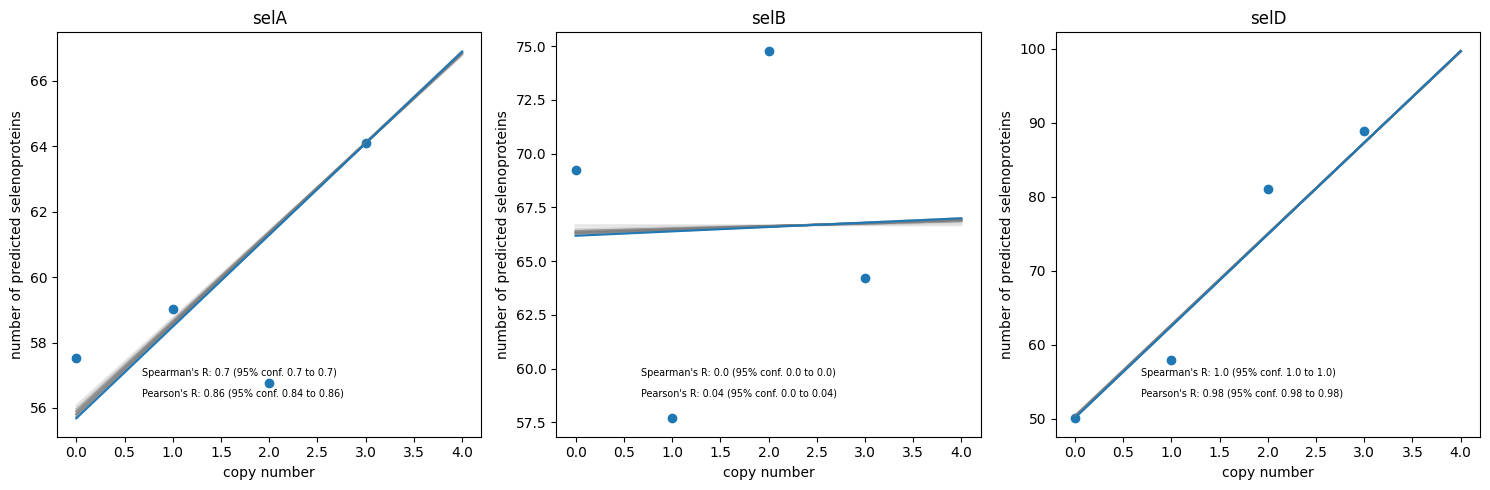

In [93]:
# Should I normalize by genome size? Seems like if I don't normalize the copy number by genome size, I shouldn't normalize the
# number of predicted selenoproteins. 

MAX_COPY_NUM = 4
X_VALS = np.linspace(0, MAX_COPY_NUM, num=100)
N_BOOTSTRAPS = 50

def get_copy_num_correlation(gtdb_results_df:pd.DataFrame, gene:str='sela') -> dict:
    '''Compute the correlation between the copy number of the specified selenoprotein-associated gene and the number of predicted
    selenoproteins in the genome.'''
    x, y = [], []

    for copy_num, df in gtdb_results_df.groupby(f'{gene}_copy_num'): # Group genomes by copy number. 
        sec_per_genome = df.groupby('genome_id').apply(len, include_groups=False).values #  / df.drop_duplicates('genome_id').protein_count.values
        y.append(np.mean(sec_per_genome)) # Get the mean number of predicted selenoproteins per genome.
        x.append(copy_num)
        # y += list(sec_per_genome)
        # x += [copy_num] * len(sec_per_genome)
    
    results = dict()
    results['x'] = np.array(x)
    results['y'] = np.array(y)
    results['spearman_r'] = scipy.stats.spearmanr(x, y).statistic
    results['pearson_r'] = scipy.stats.pearsonr(x, y).statistic

    return results


def bootstrap_copy_num_correlation(gtdb_results_df:pd.DataFrame, n_bootstraps:int=N_BOOTSTRAPS, gene:str='sela', ax:plt.Axes=None) -> Tuple:
    pearson_r, spearman_r = [], []
    n = len(sec_per_genome)

    def sample(df:pd.DataFrame):
        '''Sample such that the same number of points from each copy number are randomly-sampled.'''
        sample_df = []
        for copy_num, df in df.groupby(f'{gene}_copy_num'):
            df = df.sample(frac=1, replace=True)
            df['copy_num'] = copy_num
            sample_df.append(df)
        return pd.concat(sample_df)

    # Do I want to sample from the entire results DataFrame? Or from each individual copy number?

    for _ in range(n_bootstraps):
        results = get_copy_num_correlation(sample(gtdb_results_df), gene=gene) 
        # results = get_copy_num_correlation(gtdb_results_df.sample(frac=1, replace=True))

        if ax is not None: # Plot the best-fit line, if an axis is provided. 
            slope, intercept = np.polyfit(results['x'], results['y'], deg=1) # Get the best fit line for the correlation. 
            ax.plot(X_VALS, X_VALS * slope + intercept, c='tab:gray', alpha=0.1)
        
        pearson_r.append(results['pearson_r'])
        spearman_r.append(results['spearman_r'])

    return np.array(pearson_r), np.array(spearman_r)


def plot_copy_num_correlation(gtdb_results_df:pd.DataFrame, gene:str='sela', ax:plt.Axes=None):

    results = get_copy_num_correlation(gtdb_results_df, gene=gene)

    pearson_r, spearman_r = bootstrap_copy_num_correlation(gtdb_results_df, gene=gene, ax=ax, n_bootstraps=N_BOOTSTRAPS)
    # pearson_p = np.sum(results['pearson_r'] > pearson_r) / N_BOOTSTRAPS
    # spearman_p = np.sum(results['spearman_r'] > spearman_r) / N_BOOTSTRAPS

    scatter_x = np.arange(MAX_COPY_NUM)
    scatter_y = [np.mean(results['y'][results['x'] == i]) for i in scatter_x]
    ax.scatter(scatter_x, scatter_y, c='tab:blue')

    slope, intercept = np.polyfit(results['x'], results['y'], deg=1) # Get the best fit line for the correlation. 
    ax.plot(X_VALS, X_VALS * slope + intercept, c='tab:blue')

    conf_low, conf_high = np.round(np.quantile(pearson_r, 0.025), 2), np.round(np.quantile(pearson_r, 0.975), 2)
    ax.text(0.2, 0.1, 'Pearson\'s R: ' + str(np.round(results['pearson_r'], 2)) + f' (95% conf. {conf_low} to {conf_high})', transform=ax.transAxes, fontsize='x-small')
    conf_low, conf_high = np.round(np.quantile(spearman_r, 0.025), 2), np.round(np.quantile(spearman_r, 0.975), 2)
    ax.text(0.2, 0.15,'Spearman\'s R: ' + str(np.round(results['spearman_r'], 2)) + f' (95% conf. {conf_low} to {conf_high})', transform=ax.transAxes, fontsize='x-small')

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

for ax, gene in zip(axes, ['selA', 'selB', 'selD']):
    plot_copy_num_correlation(gtdb_results_df, ax=ax, gene=gene.lower())
    ax.set_xlabel('copy number')
    ax.set_ylabel('number of predicted selenoproteins')
    ax.set_title(gene)

plt.tight_layout()
plt.show()

In [60]:
print('Total genomes with predicted selenoproteins:', len(gtdb_results_df.genome_id.unique()))

Total genomes with predicted selenoproteins: 8712


In [58]:
# How do the results of the new model compare to those of the old model?

# old_gtdb_results_df = old_gtdb_results_df.rename(columns={'gene':'gene_id', 'Last Codon':'stop_codon', 'KO':'ko', 'selenoprotein':'prediction', 'genome':'genome_id'}).drop(columns=['gene_id_full', 'is_full_length'])
# old_gtdb_results_df['partial'] = ['00'] * len(old_gtdb_results_df)
# old_gtdb_results_df.set_index('gene_id').to_csv(os.path.join(RESULTS_DIR, 'old_gtdb_predictions.csv'))

old_gtdb_results_df = pd.read_csv(os.path.join(RESULTS_DIR, 'old_gtdb_predictions.csv'), low_memory=False)
# old_gtdb_results_df = old_gtdb_results_df[~old_gtdb_results_df.selenoprotein.isnull()]

new_gtdb_results_df = pd.read_csv(os.path.join(RESULTS_DIR, 'gtdb_results.csv'), dtype={'partial':str})
new_gtdb_results_df['gene_id'] = new_gtdb_results_df.gene_id.str.replace('.', '_') # So the gene IDs match Josh's. 
new_gtdb_results_df = new_gtdb_results_df[new_gtdb_results_df.sec_trna_count > 0] # Require at least one Sec tRNA. 
new_gtdb_results_df = new_gtdb_results_df[new_gtdb_results_df.partial.str.match('00')] # Look at only totally complete genes...

In [59]:
genes_in_new_results = len(old_gtdb_results_df[old_gtdb_results_df.gene_id.isin(new_gtdb_results_df.gene_id)])

old_genome_ids = old_gtdb_results_df.genome_id.unique()
new_genome_ids = new_gtdb_results_df.genome_id.unique()
genomes_in_new_results = np.sum(np.isin(old_genome_ids, new_genome_ids))


print(f'Fraction of original predicted selenoproteins in new results: {genes_in_new_results / len(old_gtdb_results_df)}')
print(f'Fraction of original predicted genomes in new results: {genomes_in_new_results / len(old_genome_ids)}')

print('Number of genomes in new results:', len(new_genome_ids))
print('Number of genomes in old results:', len(old_genome_ids))

Fraction of original predicted selenoproteins in new results: 0.19201799471147793
Fraction of original predicted genomes in new results: 0.14189290535473226
Number of genomes in new results: 8951
Number of genomes in old results: 6667


In [ ]:
# Number of predicted selenoproteins per genome seems way too high. 